In [1]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

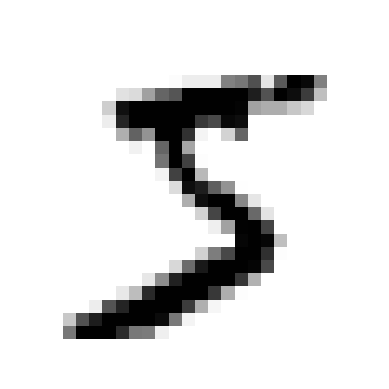

5


In [2]:
X, y = mnist["data"], mnist["target"]
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
X=X.to_numpy()
y=y.to_numpy(dtype=np.uint8)
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()
print(int(y[0]))

In [3]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
from sklearn.linear_model import SGDClassifier   #SGD为随机梯度下降
sgd_clf=SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [4]:
#交叉验证
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf=clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred=clone_clf.predict(X_test_fold)
    n_correct=sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


每个折叠由StratifiedKFold执行分层抽样产生，其所包含的各个类的比例符合整体比例。每个迭代会创建一个分类器的副本，用训练集对这个副本进行训练，然后用测试集进行预测。最后计算正确预测的次数，输出正确预测的比率。

通过分层交叉验证，评估分类器sgd_clf在不同训练/测试划分下的准确率。

交叉验证：一种模型评估方法，把训练集划分为多个折叠(fold)：
        ①每次取其中一个折叠作为验证集，其余折叠作为训练集
        ②重复训练，预测并计算准确率     ③最后取平均结果

In [5]:
#k-折交叉验证
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf=Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

准确率通常无法成为分类器的首要性能指标，尤其是在处理有偏数据集

In [6]:
#混淆矩阵：统计A类别实例被分成为B类别的次数
from sklearn.model_selection import cross_val_predict
y_train_pred =cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [7]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)
#完美的分类器只有真正类和真负类，所以它的混淆矩阵只会在正对角线上有非零值

array([[54579,     0],
       [    0,  5421]])

精度（正类预测的准确率）：精度$=\frac{TP}{TP+FP}$, 其中TP为真正类的数量，FP为假正类的数量

召回率（灵敏度，真正类率）：召回率$=\frac{TP}{TP+FN}$, FN为假负类的数量

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train_5, y_train_pred)
recall_score(y_train_5, y_train_pred)
f1_score(y_train_5, y_train_pred)

0.7325171197343847

F1分数：$F1=\frac{2}{\frac{1}{精度}+\frac{1}{召回率}} = \frac{TP}{TP+\frac{FN+FP}{2}}$

F1分数对具有相似的精度和召回率的分类器更有利。（精度/召回率权衡）

SGDClassififer的分类决策：对于每个实例，它会基于决策函数计算出一个分值，如果该值大于阈值，则将该实例判为正类，否则判定为负类

提高阈值会提高精度降低召回率；降低阈值会降低精度提高召回率

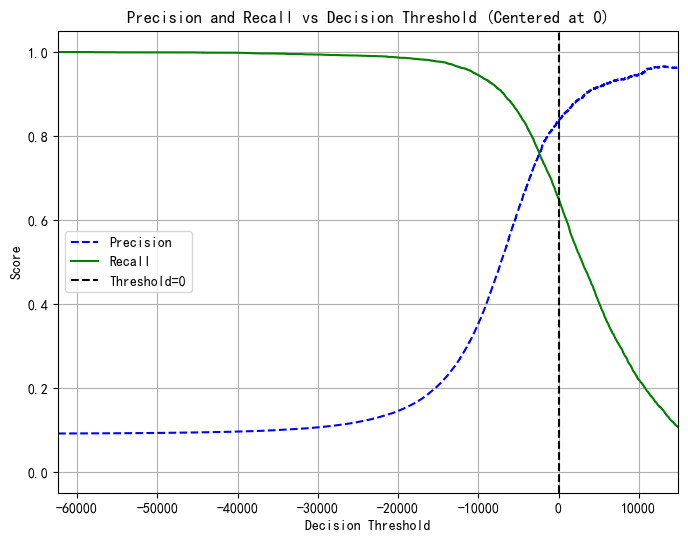

In [9]:
y_scores = sgd_clf.decision_function([some_digit])
threshold=8000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred
y_scores=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

    # 自动聚焦变化区域（避免 ±100000）
    low, high = np.percentile(thresholds, [1, 99])
    plt.xlim(low, high)

    # 在0处画竖线
    plt.axvline(x=0, color="k", linestyle="--", label="Threshold=0")

    # 标签与标题
    plt.xlabel("Decision Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall vs Decision Threshold (Centered at 0)")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# ========= 6. 调用绘图 =========
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [10]:
threshold_90_precision=thresholds[np.argmax(precisions>-0.90)]
y_train_pred_90=(y_scores>=threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)
recall_score(y_train_5, y_train_pred_90)

1.0

ROC曲线（受试者工作特征曲线）：绘制真正类率（召回率）和假正类率（FPR），即灵敏度（召回率）和（1-特异度）的关系

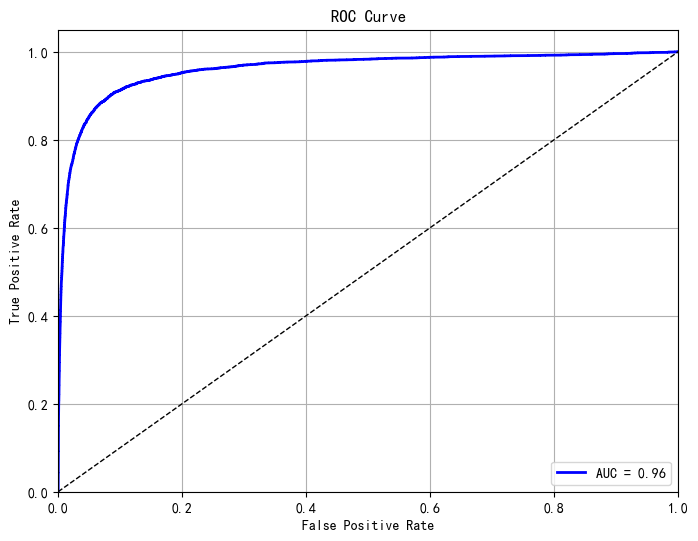

In [11]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
roc_auc = auc(fpr, tpr)  # 计算 AUC 值
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)  # 对角线
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.grid(True)
    if label:
        plt.legend(loc="lower right")

# 调用函数，并加上 AUC 标签
plot_roc_curve(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.show()


In [12]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

当正类非常少见或者更关注假正类而不是假负类时，应选择PR曲线（精度-召回率曲线），反之应该选择ROC曲线

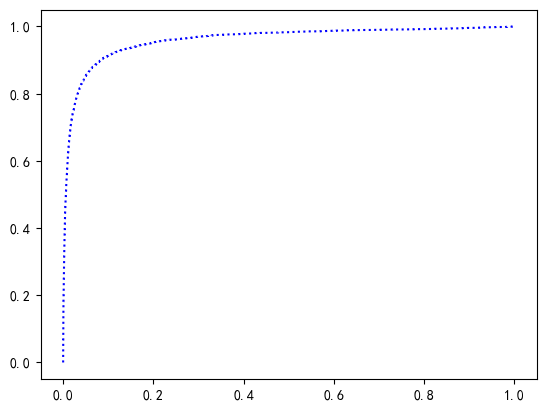

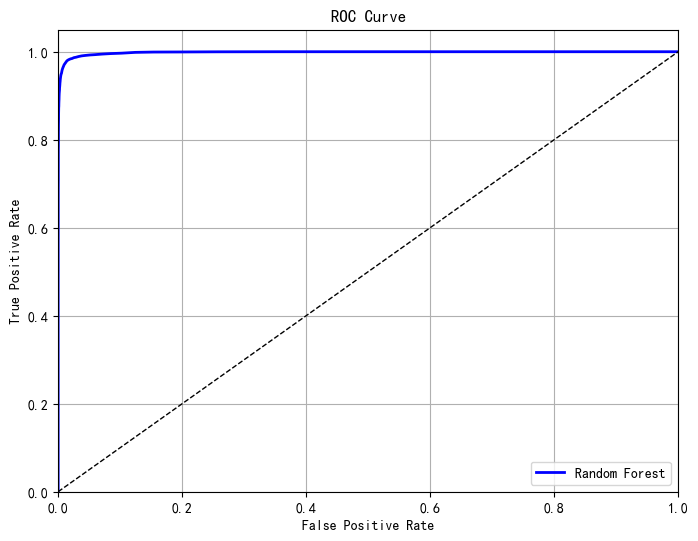

In [13]:
#随机森林分类器
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
#直接使用正类的概率作为分数值
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [14]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

随机森林分类器优于SGD分类器， 因为它的ROC曲线更靠近左上角，并且具有更大的AUC

In [ ]:
#SVM

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
lin_svm_clf = LinearSVC(C=0.01, random_state=42, max_iter=5)
lin_svm_clf.fit(X_train_scaled, y_train)

from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(kernel='linear', C=0.1, max_iter=200))
ovr_clf.fit(X_train[:5000], y_train[:5000])  # ⚠️先用小样本调试
print("预测结果:", ovr_clf.predict([some_digit]))
print("分类器数量:", len(ovr_clf.estimators_))

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

sgd_clf = SGDClassifier(random_state=42)
y_train_5 = (y_train == 5)  # 二分类标签

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()


In [17]:
# 多标签分类
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train%2==1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [18]:
y_train_knn_pred=cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

In [19]:
#多输出分类
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

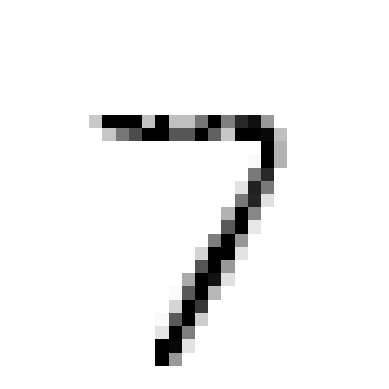

In [20]:
knn_clf.fit(X_train_mod, y_train_mod)
some_index=0
clean_digit=knn_clf.predict([X_test_mod[some_index]])
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

def plot_digit(data):
    image = data.reshape(28, 28)  # 假设是8x8的MNIST数字
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    plt.show()
plot_digit(clean_digit)